# Shaojie Ran 2031984

# Guide
## Dataset
The dataset, images required in this notebook and code file is on the github https://github.com/HappySSD/INT305.
## Python Packages  
python >= 3.7  
numpy  
pandas  
matplotlib  
seaborn  
datetime  
sklearn  
xgboost  
lightgbm  
warnings

# Loan Default Prediction Using Machine Learning Algorithms

# Introduction
With the rapid economic development, more and more people tend to use loans for consumption. This change in consumption concepts not only brings great convenience to consumers, but also promotes the development of banks and other financial institutions. At present, the credit evaluation standards of banks for customers are still only evaluating and judging the basic information provided by customers. This situation will cause the evaluation results to be unobjective, which will lead to bad results from an overall and long-term perspective. In order to improve the accuracy of personal credit evaluation and effectively reduce various costs, it is required to conduct a comprehensive analysis of customer data and establish a suitable model for personal credit prediction, and to ensure the accuracy of the model. Therefore, this project applies machine learning algorithms to the field of personal credit evaluation, which can provide a research idea for improving the credit default prediction of banks and other financial institutions. In this project, logistic regression algorithm, XGBoost algorithm, and lightGBM algorithm are used to predict the loaner default probability. The input of the predictor is the information data of the loaner containing 47 features and the output of the predictor is the the loaner default probability which is betweent 0 and 1.

# Related Work
With the widespread application of machine learning in the financial field, more and more researchers have begun to use machine learning methods to carry out risk assessment research. Orgler first applied linear regression to personal overdue risk assessment, verifying that the use of behavioral data is more capable of accurately predicting the probability of personal overdue repayment than basic information\[1\]. Chi Bo-Wen Chi and Chiun-Chieh Hsu combine logistic regression and genetic algorithms to enhance the performance of the credit scoring model and improve the prediction effect\[2\]. Finlay and Steven established a variety of boosting and bagging integrated learning models to evaluate and predict the probability of loan default, and compared them with a single machine learning model. The results show that model fusion has better predictive effects than a single model\[3\].

# Problem Formulation

## Data
This data set is derived from loan records of a credit platform\[4\]. Each record in the data represents the information of a loaner. It contains around 20w samples and each sample has 47 features, including 15 anonymous features. The isDefault feature is the label feature. This project uses the train_test_split method of the sklearn library to divide the data into a training set and a test set. The training data set accounts for 80% of the total amount of data, and the test data set accounts for 20% of the total amount of data. The data structure and description are as following table:
![data_description](./loan_data_description.png)

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

In [18]:
#import the data
data = pd.read_csv('./data.csv')

## Data Process
Firstly, I conduct a data analysis for the data, including checking the missing value of data, inspecting the distribution of category features, and visualizing the correlation between features. The feature engineering is performed based on the result of data analysis. In the feature engineering stage, I fill the missing value by the strategy that filling the numerical feature with feature mean value and filling the category feature with feature mode value. The label encode method is utilized to convert object features into numerical features.

In [19]:
# split the numerical feature and category feature
numerical_fea = list(data.select_dtypes(exclude=['object']).columns)
category_fea = list(filter(lambda x: x not in numerical_fea,list(data.columns)))
numerical_fea.remove('isDefault')

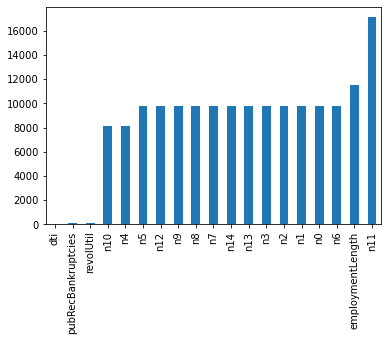

In [20]:
# visualize the features with missing value
missing = data.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

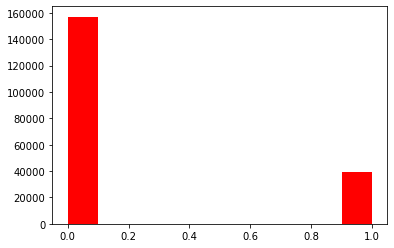

In [21]:
#plot the distribution of label feature
plt.hist(data['isDefault'], orientation = 'vertical',histtype = 'bar', color ='red')
plt.show()

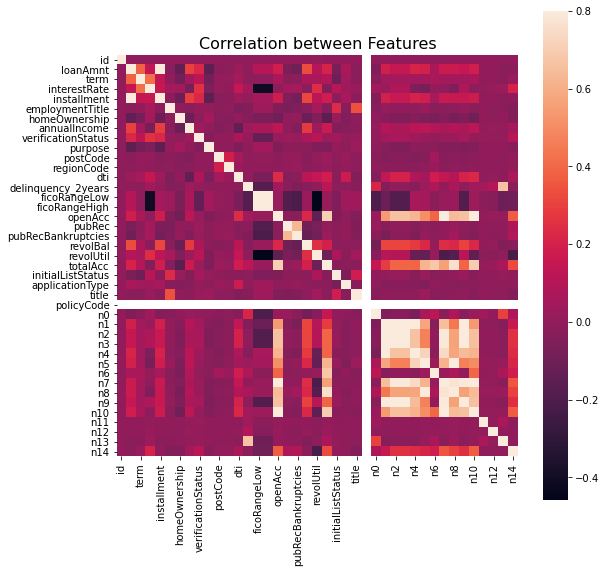

In [22]:
#plot the correlation of features
correlation = data[numerical_fea].corr()
f, ax = plt.subplots(figsize = (9, 9))
plt.title('Correlation between Features',y=1,size=16)
sns.heatmap(correlation,square = True,  vmax=0.8)

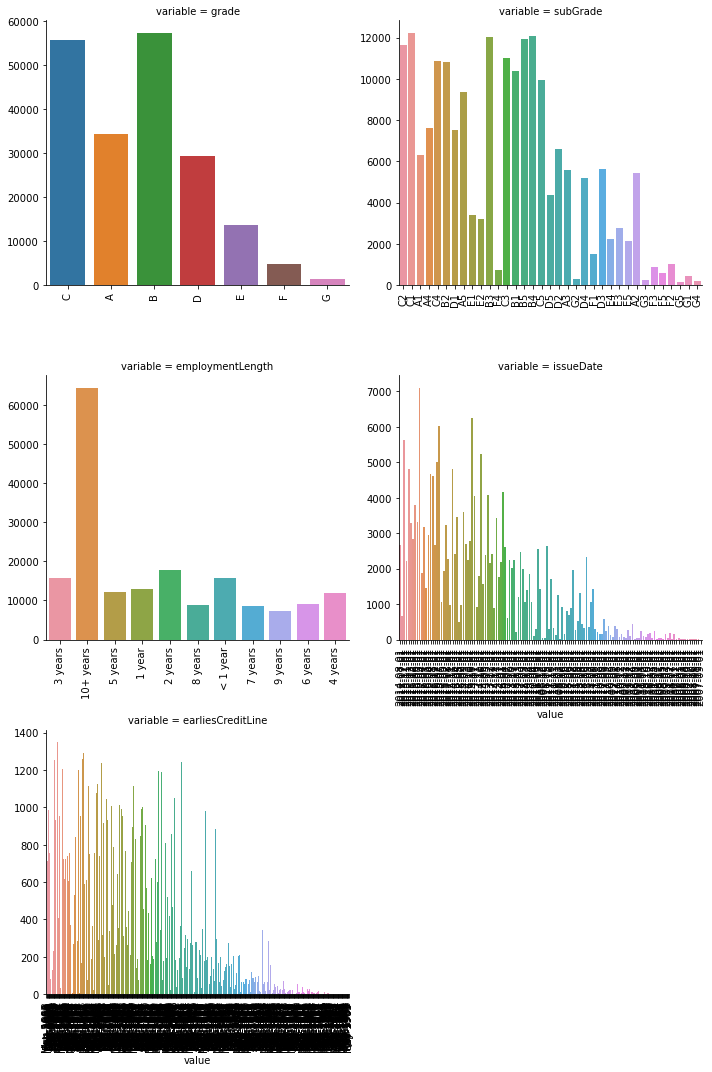

In [23]:
#plot the distribution of category features
def count_plot(x,  **kwargs):
    sns.countplot(x=x)
    x=plt.xticks(rotation=90)

f = pd.melt(data, value_vars=category_fea)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(count_plot, "value")

In [24]:
#split the data into train dataset and test dataset
X_data = data.drop('isDefault',axis=1)
y_data = data['isDefault']
X_train,X_test,y_train,y_test=train_test_split(X_data,y_data,test_size=0.2,random_state=50)

In [25]:
#fill the missing value
#fill the numerical feature with feature mean value
for fea in numerical_fea:
    X_train[fea].fillna(X_train[fea].mean(),inplace=True)
    X_test[fea].fillna(X_test[fea].mean(),inplace=True)
#fill the category feature with feature mode value
for fea in category_fea:
    X_train[fea].fillna(X_train[fea].mode().values[0],inplace=True)
    X_test[fea].fillna(X_test[fea].mode().values[0],inplace=True)

In [26]:
#label encode the object feature
for data in [X_train,X_test]:
    data['issueDate'] = pd.to_datetime(data['issueDate'],format='%Y-%m-%d')
    startdate = datetime.strptime('2007-06-01', '%Y-%m-%d')
    data['issueDateDT'] = data['issueDate'].apply(lambda x: x-startdate).dt.days
    data['grade'] = data['grade'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7})
    data['employmentLength'] = data['employmentLength'].map({'1 year':1,'2 years':2,'3 years':3,'4 years':4,'5 years':5,'6 years':6,'7 years':7,'8 years':8,'9 years':9,'10+ years':10,'< 1 year':0})
    data['subGrade'] = data['subGrade'].map({'E2':1,'D2':2,'D3':3,'A4':4,'C2':5,'A5':6,'C3':7,'B4':8,'B5':9,'E5':10,
        'D4':11,'B3':12,'B2':13,'D1':14,'E1':15,'C5':16,'C1':17,'A2':18,'A3':19,'B1':20,
        'E3':21,'F1':22,'C4':23,'A1':24,'D5':25,'F2':26,'E4':27,'F3':28,'G2':29,'F5':30,
        'G3':31,'G1':32,'F4':33,'G4':34,'G5':35})
    data['earliesCreditLine'] = data['earliesCreditLine'].apply(lambda s: int(s[-4:]))

In [27]:
# delete the useless feature and the redundant feature which has high correlation with other feature
for data in [X_train, X_test]:
    data.drop(['id','issueDate','ficoRangeHigh','installment','n3','n7','n9','n10'], axis=1,inplace=True)

# Methods
This project uses logistic regression, xgboost, and lightGBM algorithms to predict the probability of loaner default. The AUC serves as a metric to evaluate the performance of the model. The sklearn machine learning library was used in the project for model training and cross-validation. First, I use 5 folds cross-validation methods to train three models in the training set, and get the cross-validation score of each model.Then, the model with the best performance is selected based on the cross-validation score, and is applied to the test data to verify its performance.

## Logistic Regression
Logistic Regression is a machine learning method used to solve two classification problem, which is used to estimate the possibility of something. The model function is as following formulations:  

$h_w(x)=g(w^Tx)$  

$g(z)=\frac{1}{1+e^(-z)}$  

In the formulations, $w$ presents the parameter vector, $x$ presents the input and $h$ presents the output.

## XGBoost
XGBoost is essentially a Gradient Boosting Decision Tree. It attempts to continually add trees and perform feature splits to generate a new tree. After each time it adds a tree, it actually learns a new function $\mathcal{F}$ and then fits the residuals of the last prediction. After training $k$ trees, we predict the value of a sample, which is actually based on the features of this sample, corresponding to the leaf nodes of each tree, to get score. Finally, we get the prediction value of sample by adding sores for each tree. The formula for the definition is as follows:   

$\hat{y}_{i}=\phi\left(\mathbf{x}_{i}\right)=\sum_{k=1}^{K} f_{k}\left(\mathbf{x}_{i}\right), \quad f_{k} \in \mathcal{F}$  

$\mathcal{D}=\left\{\left(\mathbf{x}_{i}, y_{i}\right)\right\}\left(|\mathcal{D}|=n, \mathbf{x}_{i} \in \mathbb{R}^{m}, y_{i} \in \mathbb{R}\right)$  

$\mathcal{F}=\left\{f(\mathbf{x})=w_{q(\mathbf{x})}\right\}\left(q: \mathbb{R}^{m} \rightarrow T, w \in \mathbb{R}^{T}\right)$  

## LightGBM
LightGBM is a Light Gradient Boosting Machine. The main difference between LightGBM and XGBoost is the tree construction, instead of growing a tree row by row, LightGBM grows the tree according to the leaves. It implements a highly optimised histogram-based decision tree learning algorithm that offers significant advantages in terms of efficiency and memory consumption.

# Experiment and Result

## Experiment
The experiment is divided into two parts.  
First, I use 5 fold cross-validation method to train the model in the training set, and use AUC to evaluate the quality of the model. AUC formula is as following: $AUC = \frac{\sum_{postives}k-\frac{n_{pos}(n_{pos}+1)}{2}}{n_{pos}n_{neg}}$. In the case of unbalanced samples, AUC can still make a reasonable evaluation of the classifier\[5\]. In this problem, we can see that the distribution of the label feature $isDefault$ is not balanced, so AUC metric is a good choice.

Second, based on the cross-validation score of three models, I choose the best performance model and apply this model to the test set to verify its performance.

In [28]:
models = [LogisticRegression(),XGBRegressor(),LGBMRegressor()]

In [29]:
#apply 5 folds corss-validation to selecting model
result={}
for model in models:
    scores = cross_val_score(model, X_train, y_train, cv=5,scoring='roc_auc')
    model_name = str(model).split("(")[0]
    result[model_name]=scores
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

,LogisticRegression,XGBRegressor,LGBMRegressor
cv1,0.620212,0.716469,0.726246
cv2,0.616570,0.715470,0.726923
cv3,0.617020,0.715580,0.725567
cv4,0.623084,0.722377,0.731285
cv5,0.613242,0.716061,0.726225


## Result
Based on the cross-validation score on the table, I plot a chart to make the comparison more intuitive. We can see that the lightGBM model has higer AUC score than other two models in each fold. So, I apply the lightGBM model to the test set and plot the ROC curve. The AUC score of lightGBM in the test set is 0.7314 which is a acceptable result. Since the socre of AUC in training set and test set is quite close, there is no overfitting in the training set and the the model has a good performance in the new data.

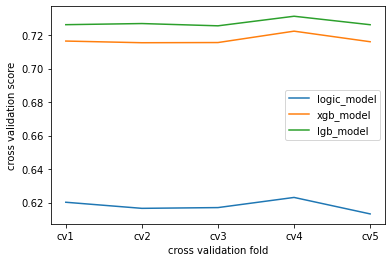

In [30]:
plt.plot(result)
plt.xlabel('cross validation fold')
plt.ylabel('cross validation score')
plt.legend(['logic_model','xgb_model','lgb_model'])

In [31]:
#apply lightGBM to test set
gbm = LGBMRegressor()
gbm.fit(X_train,y_train)
gbm_predict_val = gbm.predict(X_test)

AUC of lightGBM in test set: 0.7314153787035117


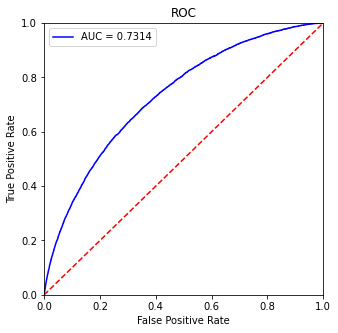

In [32]:
#plot the ROC curve of lightGBM in test set
fpr, tpr, threshold = metrics.roc_curve(y_test, gbm_predict_val)
roc_auc = metrics.auc(fpr, tpr)
print('AUC of lightGBM in test set: {}'.format(roc_auc))
plt.figure(figsize=(5, 5))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.ylim(0,1)
plt.xlim(0,1)
plt.legend(loc='best')
plt.title('ROC')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0,1],[0,1],'r--')
plt.show()

# Conclusion and Future Works
After a series of experiments, it is obtained that the lightGBM model has good prediction accuracy for the loan default prediction problem, and outperforms other machine learning methods. Meanwhile, the model shows a good generalization ability to deal with new data. However, in the experiment, I do not conduct an in-depth mining of features. In future research, I will construct some new valuable features based on financial knowledge to improve the model accuracy.

# Bibliography

\[1\] Orgler Y E . A Credit Scoring Model for Commercial Loans[J]. Journal of Money, Credit and  Banking, 1970, 2(4):435-445.  

\[2\] Chi B W , Hsu C C . A hybrid approach to integrate genetic algorithm into dual scoring
model in enhancing the performance of credit scoring model[J]. Expert Systems with
Applications, 2012, 39(3):2650-2661.  

\[3\] Finlay S . Multiple classifier architectures and their application to credit risk assessment[J]. European Journal of Operational Research, 2011, 210(2):368-378.  

\[4\] https://tianchi.aliyun.com/competition/entrance/531830/information

\[5\] Ling C X, Huang J, Zhang H. AUC: a statistically consistent and more discriminating measure than accuracy[C]//Ijcai. 2003, 3: 519-524.